In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [ ]:
# =============================
# 1. Persiapan Dataset CIFAR-10
# =============================

transform = transforms.Compose([
    transforms.ToTensor(),  # Ubah ke tensor [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalisasi
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# =============================
# 2. Arsitektur AlexNet CIFAR-10
# =============================

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

In [ ]:
# =============================
# 3. Pelatihan Model (dengan Visualisasi)
# =============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetCIFAR10().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []  # Simpan loss tiap epoch

print("Mulai training...\n")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'batch_loss': loss.item()})

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Mulai training...



Epoch 1/10, Loss: 1.6804


Epoch 2/10, Loss: 1.2915


Epoch 3/10, Loss: 1.1144


Epoch 4/10, Loss: 0.9995


Epoch 5/10, Loss: 0.9087


Epoch 6/10, Loss: 0.8320


Epoch 7/10, Loss: 0.7780


Epoch 8/10, Loss: 0.7183


Epoch 9/10, Loss: 0.6698


Epoch 10/10, Loss: 0.6340


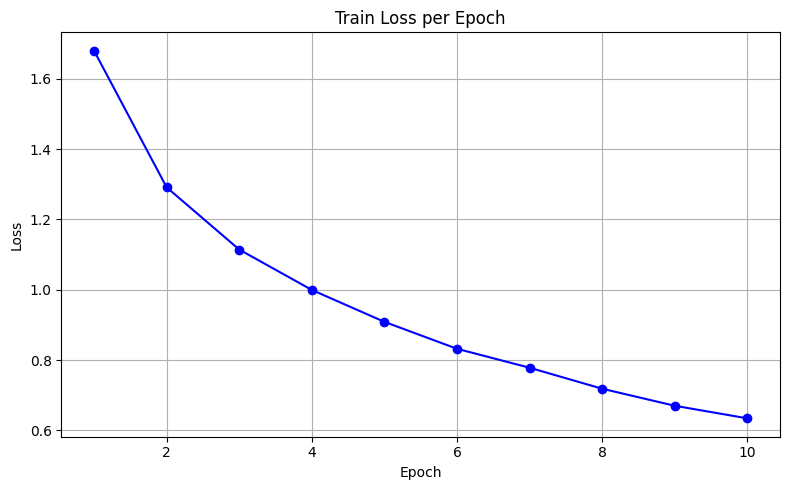

In [ ]:
# =============================
# 4. Visualisasi Loss per Epoch
# =============================

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='blue')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# =============================
# 5. Evaluasi Akurasi Test Set
# =============================

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nTest Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 73.71%


In [ ]:
# =============================
# 6. Akurasi per kelas (Per-Class Accuracy)
# =============================

class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Tampilkan hasil
print("\nAkurasi per kelas:")
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]:<10s} : {accuracy:.2f}%")


Akurasi per kelas:
airplane   : 78.70%
automobile : 82.50%
bird       : 68.40%
cat        : 56.90%
deer       : 66.00%
dog        : 66.30%
frog       : 72.20%
horse      : 78.80%
ship       : 84.30%
truck      : 83.00%


In [ ]:
# Ambil semua prediksi dan label dari test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Hitung confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))  # 10 = jumlah kelas CIFAR-10

# Inisialisasi TP, FP, FN, TN
TP = np.zeros(10)
FP = np.zeros(10)
FN = np.zeros(10)
TN = np.zeros(10)

for i in range(10):
    TP[i] = cm[i, i]
    FP[i] = cm[:, i].sum() - TP[i]
    FN[i] = cm[i, :].sum() - TP[i]
    TN[i] = cm.sum() - (TP[i] + FP[i] + FN[i])

# Tampilkan hasil per kelas
print("\n TP, FP, FN, TN per kelas:")
for i in range(10):
    print(f"{classes[i]:<10s} | TP: {int(TP[i])}  FP: {int(FP[i])}  FN: {int(FN[i])}  TN: {int(TN[i])}")


 TP, FP, FN, TN per kelas:
airplane   | TP: 787  FP: 300  FN: 213  TN: 8700
automobile | TP: 825  FP: 87  FN: 175  TN: 8913
bird       | TP: 684  FP: 478  FN: 316  TN: 8522
cat        | TP: 569  FP: 517  FN: 431  TN: 8483
deer       | TP: 660  FP: 256  FN: 340  TN: 8744
dog        | TP: 663  FP: 374  FN: 337  TN: 8626
frog       | TP: 722  FP: 116  FN: 278  TN: 8884
horse      | TP: 788  FP: 216  FN: 212  TN: 8784
ship       | TP: 843  FP: 157  FN: 157  TN: 8843
truck      | TP: 830  FP: 128  FN: 170  TN: 8872


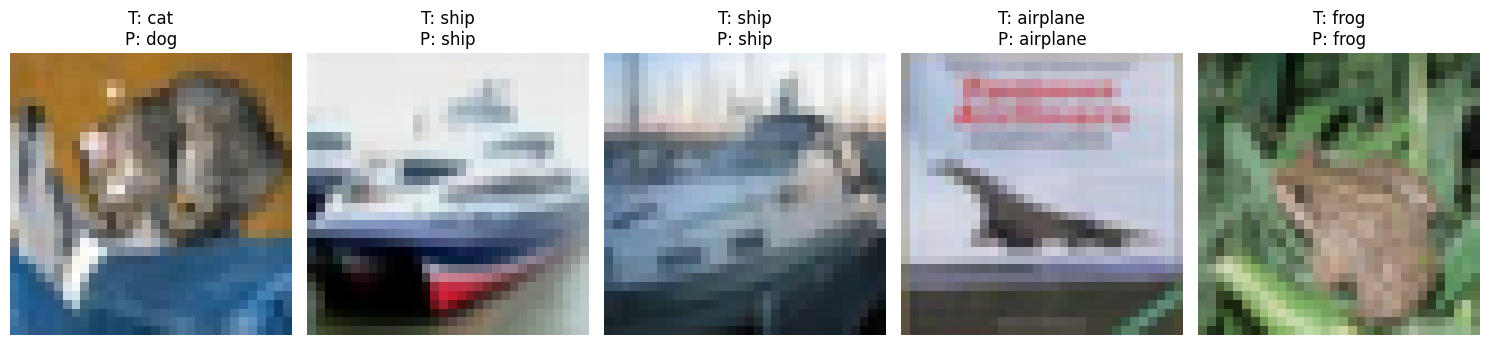

In [ ]:
# =============================
# 7. Inference (Prediksi 1 Gambar)
# =============================

# Fungsi untuk denormalisasi dan menampilkan banyak gambar
def imshow_batch(images, labels_true, labels_pred, classes, count=5):
    images = images[:count]
    labels_true = labels_true[:count]
    labels_pred = labels_pred[:count]

    images = images / 2 + 0.5  # Denormalisasi

    fig, axes = plt.subplots(1, count, figsize=(15, 4))
    for i in range(count):
        img = images[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"T: {classes[labels_true[i]]}\nP: {classes[labels_pred[i]]}")
    plt.tight_layout()
    plt.show()

# Ambil batch gambar dari testloader
dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

# Inference model
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Tampilkan hasil prediksi 5 gambar pertama
imshow_batch(images.cpu(), labels.cpu(), predictions.cpu(), classes, count=5)